# Predict Drought Level using Weather Dataset

##### Linoy Davari, Shachar Welkovitz and Yael Simhis

https://www.kaggle.com/cdminix/us-drought-meteorological-data





## Part 1 - Intro

https://drive.google.com/file/d/1kTS8geP0aHgDLPsinXDa9idvDgUDVRUf/view?usp=sharing


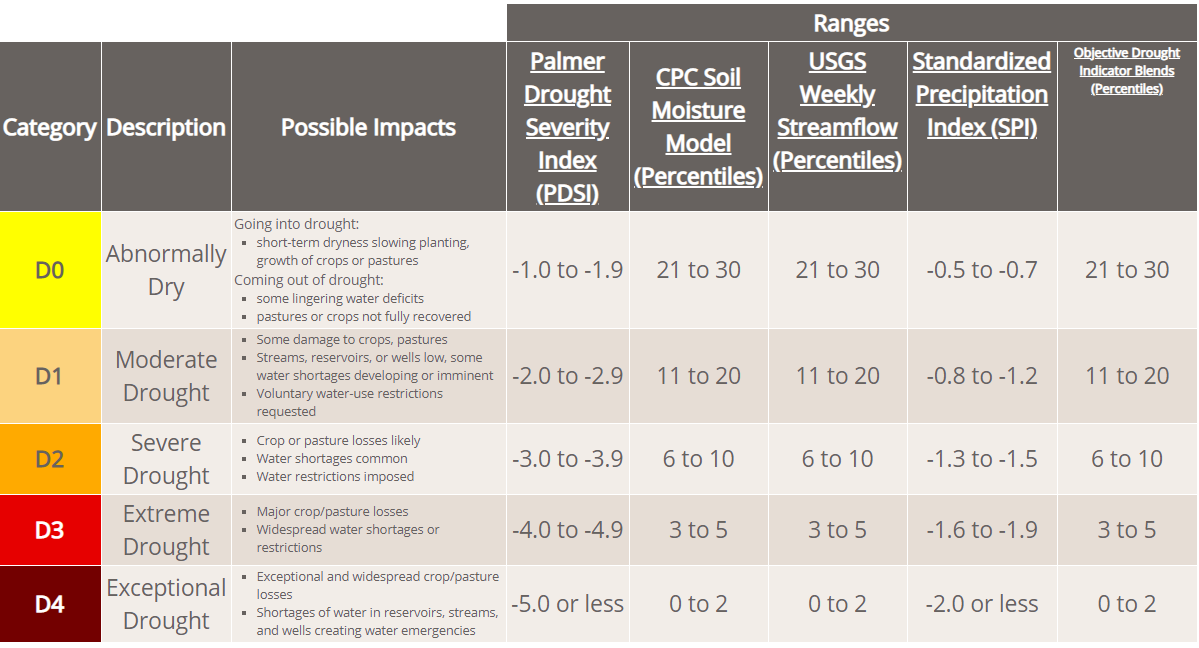

## Part 2 - Import Libraries

In [4]:
!pip install shap

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import os

sns.set()
sns.set_style('white')

from scipy.interpolate import interp1d
from scipy.optimize import minimize
import scipy.stats as scs
import altair as alt
from tqdm.auto import tqdm
from tqdm.notebook import tqdm
from datetime import datetime

import sklearn
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import utils
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV
from xgboost import XGBRegressor

import shap
import itertools
from itertools import product

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings('ignore')

#### Define Constant Variables 

In [6]:
TITLE_SIZE = 18
XLABEL_SIZE = 12
YLABEL_SIZE = 12
FIG_SIZE = (8,4)

## Part 3 - Loading the Data

In [7]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download cdminix/us-drought-meteorological-data
! unzip us-drought-meteorological-data.zip

root_path = '/content/'

files = {}

for dirname, _, filenames in os.walk(root_path):
  for filename in filenames:
    if filename == 'test_timeseries.csv':
        files['test'] = os.path.join(dirname, filename)
    if filename == 'train_timeseries.csv':
        files['train'] = os.path.join(dirname, filename)
    if filename == 'validation_timeseries.csv':
        files['validation'] = os.path.join(dirname, filename)

train_data = pd.read_csv(files['train'])
test_data = pd.read_csv(files['test'])
validation_data = pd.read_csv(files['validation'])

 99% 896M/901M [00:16<00:00, 61.5MB/s]
100% 901M/901M [00:16<00:00, 58.1MB/s]
Archive:  us-drought-meteorological-data.zip
  inflating: soil_data.csv           
  inflating: test_timeseries/test_timeseries.csv  
  inflating: train_timeseries/train_timeseries.csv  
  inflating: validation_timeseries/validation_timeseries.csv  


#### Drop rows with null values and Set the datetime column as index.

In [8]:
train_data = train_data.dropna()

train_data.date = pd.to_datetime(train_data.date)
train_data.set_index('date', inplace=True)

## Part 4 - Data Visualization

####4.1. Occurrences of each drought level

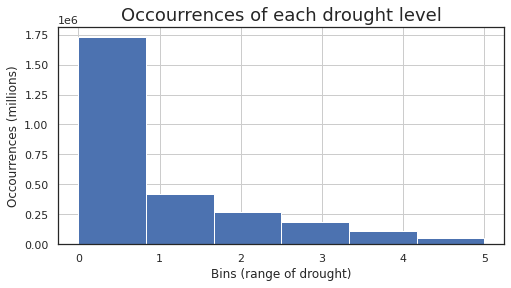

In [9]:
train_data.score.hist(bins=6, figsize=FIG_SIZE)
plt.xlabel("Bins (range of drought)", size=XLABEL_SIZE)
plt.ylabel("Occourrences (millions)", size=YLABEL_SIZE)
plt.title("Occourrences of each drought level", size=TITLE_SIZE)
plt.show()



*   There is an inequality in the drought levels quantities.
*   Most of the examples in the dataset have no drought at all (1.75 milion examples with score between 0 and 1).



####4.2. Correlations between features - Heat Map

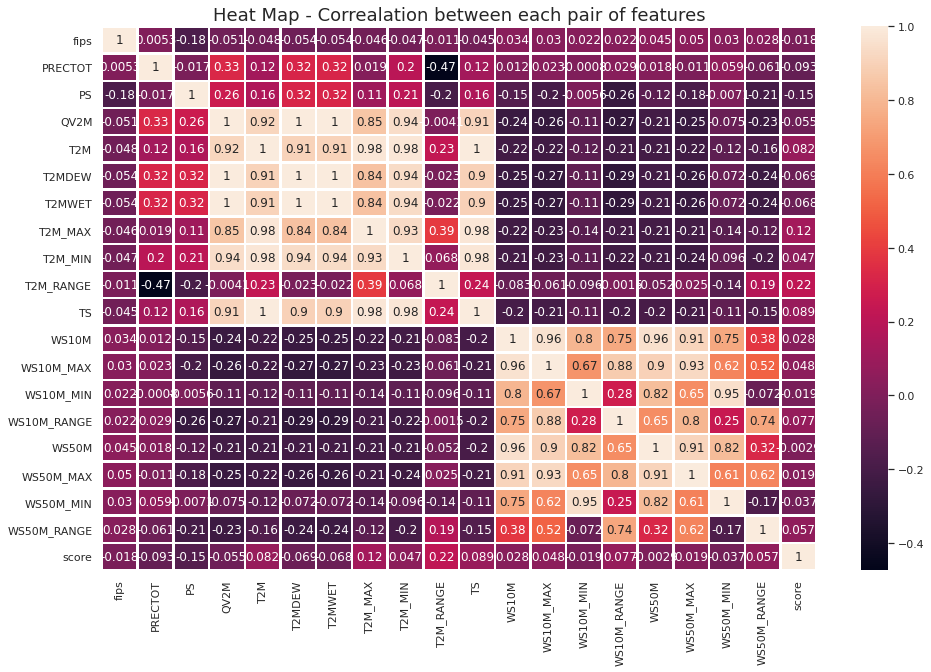

In [10]:
fix, ax = plt.subplots(figsize=(16,10))
plt.title("Heat Map - Correalation between each pair of features", size=TITLE_SIZE)
sns.heatmap(train_data.corr(method='spearman'),annot=True,linewidths=1.5)
plt.show()

The features that have the highest correlation with the target column, score are:

*   T2M_RANGE with 0.22 correlation rate.
*   T2M_MAX with 0.12 correlation rate.



####4.3. Exploring the Heat Map

#####4.3.1. Occurrences of the features that have the highest correlation with the target column

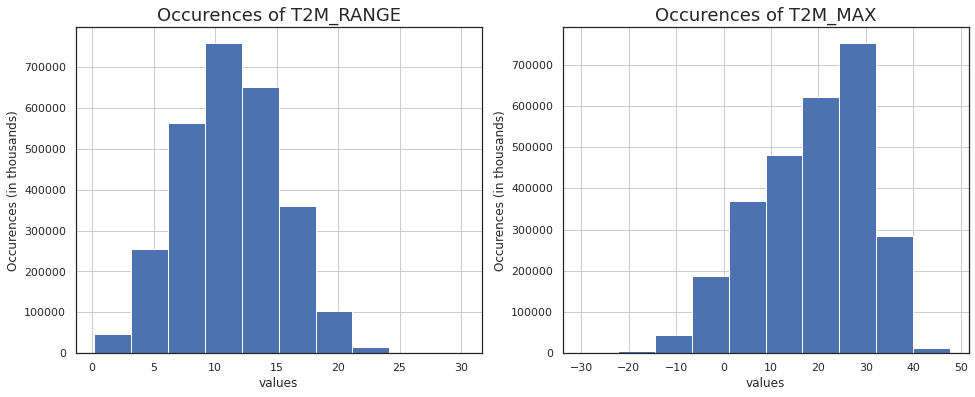

In [11]:
numeric_variables = ['T2M_RANGE','T2M_MAX']
fig, axes = plt.subplots(1, len(numeric_variables),figsize=(16,6))

for ind,var in enumerate(numeric_variables):
    train_data[var].hist(ax=axes[ind])
    axes[ind].set_title("Occurences of " + var, size=TITLE_SIZE)
    axes[ind].set_xlabel("values", size=XLABEL_SIZE)
    axes[ind].set_ylabel("Occurences (in thousands)", size=YLABEL_SIZE)

**T2M_RANGE** - The Temperature Range at 2 Meters:
*   is between 0 to 25.

*   The temperature range indicates that there are different temperature levels in the dataset to explore.

**T2M_MAX** - The Maximum Temperature at 2 Meters:
*   is between -20 to 50.

*   There are many examples with high maximum temperature that can indicate an high drought level.





#####4.3.2. The Affect of T2M_RANGE and WS50M_RANGE on the score



*   The WS50M_RANGE is the wind range speed at 50 Meters.
*   The T2M_RANGE is the temperature range at 2 Meters.
*   The range in both cases is the difference between the maximum value and the minimum value.
*   T2M_RANGE and WS50M_RANGE correlation rate is 0.19 which is approximately the same as the correlation between T2M_RANGE and score.

In [12]:
var_a = 'T2M_RANGE'
var_b = 'WS50M_RANGE'

data = train_data[:5000]
alt.Chart(data, title='Wind Speed and Temperature Affect on Score').mark_point().encode(
     x= var_a,
     y= var_b,
     color='score'
 ).interactive()

alt.Chart(...)

*   We can conclude that **low wind range** and **high temprature range** may cause in most cases an high score.


*   *Note: This graph is showing the results for only 5000 examples.*




#####4.3.3. The Affect of T2M_MAX and PS on the score 

*   The PS is the Atmospheric Pressure.
*   The T2M_MAX is the maximum temperature measured at 2 meters.
*   T2M_MAX and PS correlation rate is 0.11 which is approximately the same as the correlation between T2M_MAX and score.

In [13]:
var_a = 'T2M_MAX'
var_b = 'PS'

data = train_data[:5000]
alt.Chart(data, title='Atmospheric Pressure and Max Temperature Affect on Score').mark_point().encode(
     x= var_a,
     y= var_b,
     color='score',
 ).interactive()

alt.Chart(...)

*   We can conclude that **high maximum temperature** causes **high score**.
*   The PS rate has no drastic change, so it's not affecting the score.


*   *Note: This graph shows the results for only 5000 examples.*

####4.4. Seasonality, Trends and Stationarity

#####4.4.1. Resampling the Data by Years and Months

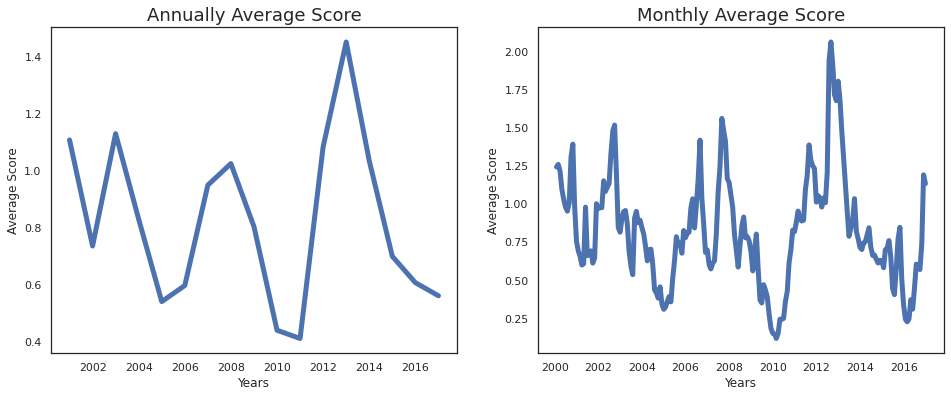

In [14]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
train_dataY = train_data.resample("Y").mean()
plt.plot(train_dataY.score, linewidth=5)
plt.title('Annually Average Score', size=TITLE_SIZE)
plt.xlabel('Years', size=XLABEL_SIZE)
plt.ylabel('Average Score', size=YLABEL_SIZE)

plt.subplot(1, 2, 2)
train_dataM = train_data.resample("M").mean()
plt.plot(train_dataM.score, linewidth=5)
plt.title('Monthly Average Score', size=TITLE_SIZE)
plt.xlabel('Years', size=XLABEL_SIZE)
plt.ylabel('Average Score', size=YLABEL_SIZE)

plt.show()

**Annually Average Score:**
* It seems that there is no monotonic trend, but there are ups and downs.

* At 2011 the average score was 0.4 which is the lowest average score from 2000 to 2016.

* There is a sharp increase from 2011 to 2013 - the highset record was noted in 2013 and is approximately 1.5.

**Monthly Average Score:**
* Every year starts with high average score, than it drops down and at the end it increases up again.

* We can see as well a sharp increase by the years 2011-2013. 






#####4.4.2. Resampling the Data by weeks



*   We will work with data resampled by weeks.



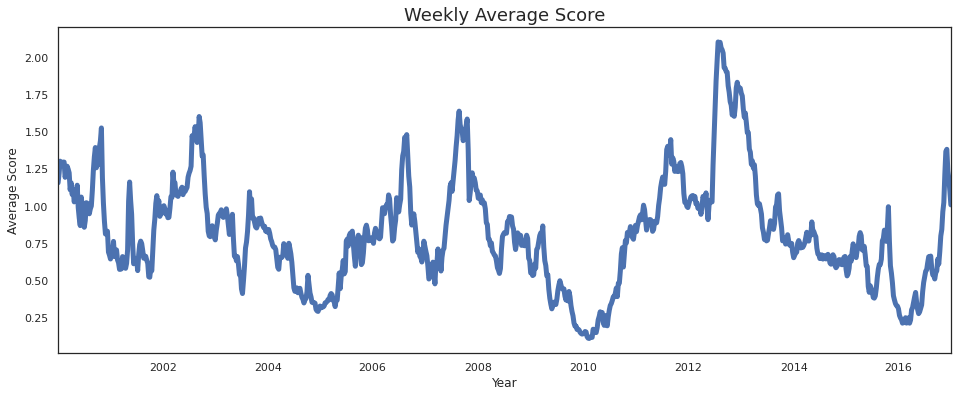

In [15]:
dfw = train_data.resample("W").mean()
dfw.score.plot(figsize=(16,6), linewidth=5)
plt.xlabel('Year', fontsize=XLABEL_SIZE)
plt.ylabel('Average Score', fontsize=YLABEL_SIZE)
plt.title('Weekly Average Score', fontsize=TITLE_SIZE)
plt.show()

#####4.4.3. Plot the Rolling Average by Quarters

*   *window size=12 - the average score by Quarters.*


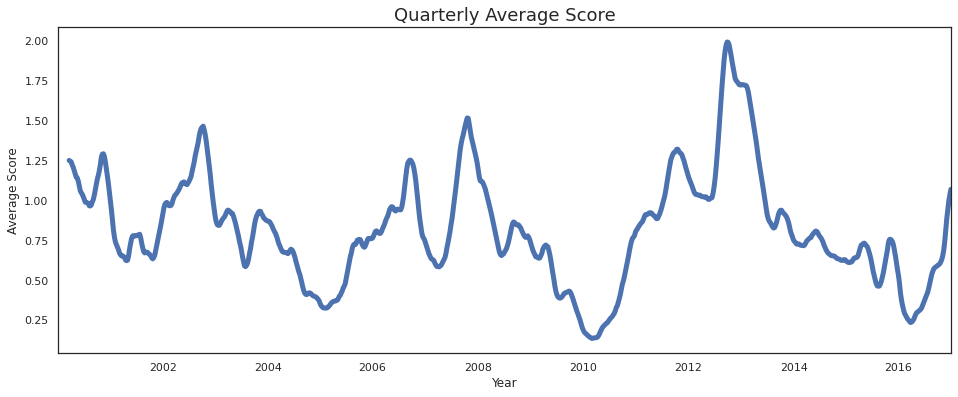

In [16]:
dfw.score.rolling(12).mean().plot(figsize=(16,6), linewidth=5)
plt.xlabel('Year', fontsize=XLABEL_SIZE)
plt.ylabel('Average Score', fontsize=YLABEL_SIZE)
plt.title('Quarterly Average Score', fontsize=TITLE_SIZE)
plt.show()

Both graphs, from part **4.4.2** and **4.4.3** helps us understand about Seasonality and Trends in our data:

*   **Seasonality:**
    *  Every year starts with low average score, then the average rises and eventually it decreases again.
    *   It makes sense that in summer the drought score is higher than in winter.
    * to conclude: our data has seasonality.

*   **Trends:**
    * There are years with high drought score, but also years with very low score.
    * We can see intermittent ups and downs over the years 2000-2016.
    * to conclude: our data has Trends.




#####4.4.4 Autocorrelation



*   To understand better if our data is stationary, let's take a look at the ACF graph: 



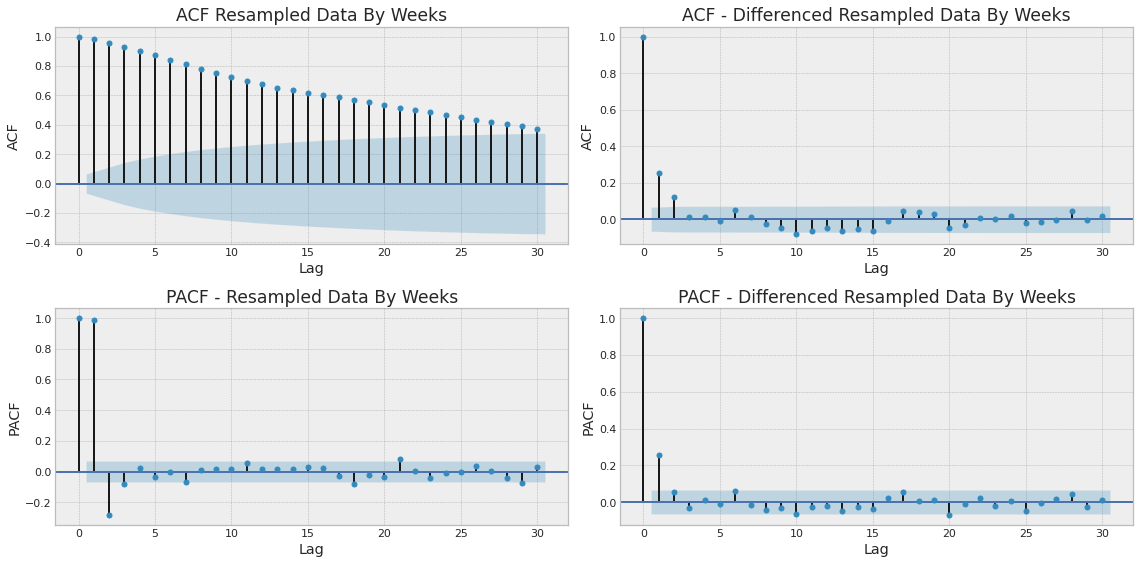

In [ ]:
def tsplot(y, lags=None, figsize=(16, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):  
        fig = plt.figure(constrained_layout=True, figsize=figsize)
        spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
        acf_ax = fig.add_subplot(spec2[0, 0], xlabel='Lag', ylabel='ACF')
        dacf_ax = fig.add_subplot(spec2[0, 1], xlabel='Lag', ylabel='ACF')
        pacf_ax = fig.add_subplot(spec2[1, 0], xlabel='Lag', ylabel='PACF')
        dpacf_ax = fig.add_subplot(spec2[1, 1], xlabel='Lag', ylabel='PACF')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, title='ACF Resampled Data By Weeks')
        smt.graphics.plot_acf(y.diff().dropna(), lags=lags, ax=dacf_ax, title='ACF - Differenced Resampled Data By Weeks')
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, title='PACF - Resampled Data By Weeks')
        smt.graphics.plot_pacf(y.diff().dropna(), lags=lags, ax=dpacf_ax, title='PACF - Differenced Resampled Data By Weeks')
        plt.tight_layout()
        
tsplot(dfw.score, lags=30)

* The ACF (top left graph) declines slowly toward zero, hence the data is **non-stationary**. Another cause is that the mean and variance are inconstant, as seen on 4.4.3.

* Adding a 1st order difference to our data (top right graph) shows that the ACF drops to zero relatively quickly. That means the data is **stationary** after 1st order of difference, so we don't need a 2nd order difference.

* Below you can see the graph of the 1st order difference.

* We also created PACF graphs that will help us in the next Part - Arima model.

* The number of Lags we chose is 30 based on the formula: $10 × \log_{10}(length)$ for a time series data as recommended in the article https://methods.sagepub.com/base/download/DatasetStudentGuide/time-series-acf-pacf-in-us-feedgrains-1876-2015.





#####4.4.5. First Order Difference 

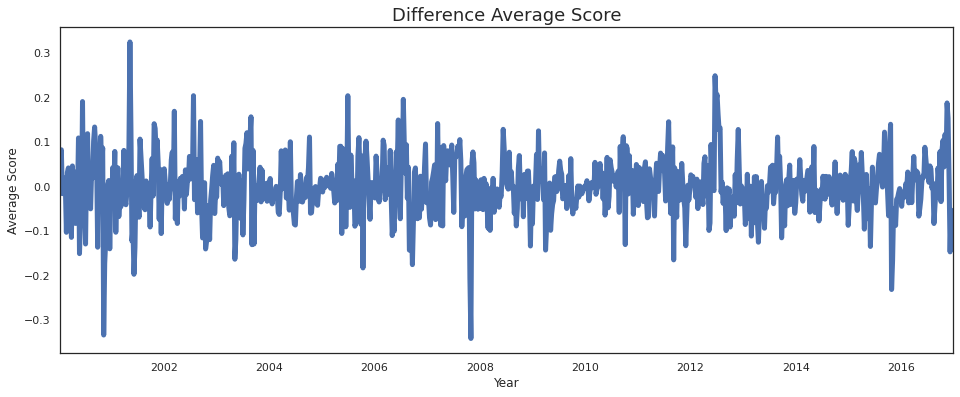

In [17]:
dfw_diff = dfw.diff().dropna()
dfw_diff.score.plot(figsize=(16,6), linewidth=5)
plt.xlabel('Year', fontsize=XLABEL_SIZE)
plt.ylabel('Average Score', fontsize=YLABEL_SIZE)
plt.title('Difference Average Score', fontsize=TITLE_SIZE)
plt.show()

 

*   From the graph we can see unusual peaks around the year: 2001, 2002, 2008, 2012 and 2016.
*   Here are some explanations for these peaks: (Taken From Wikipedia) 

  * *Note:* **What happened in 2002?** 
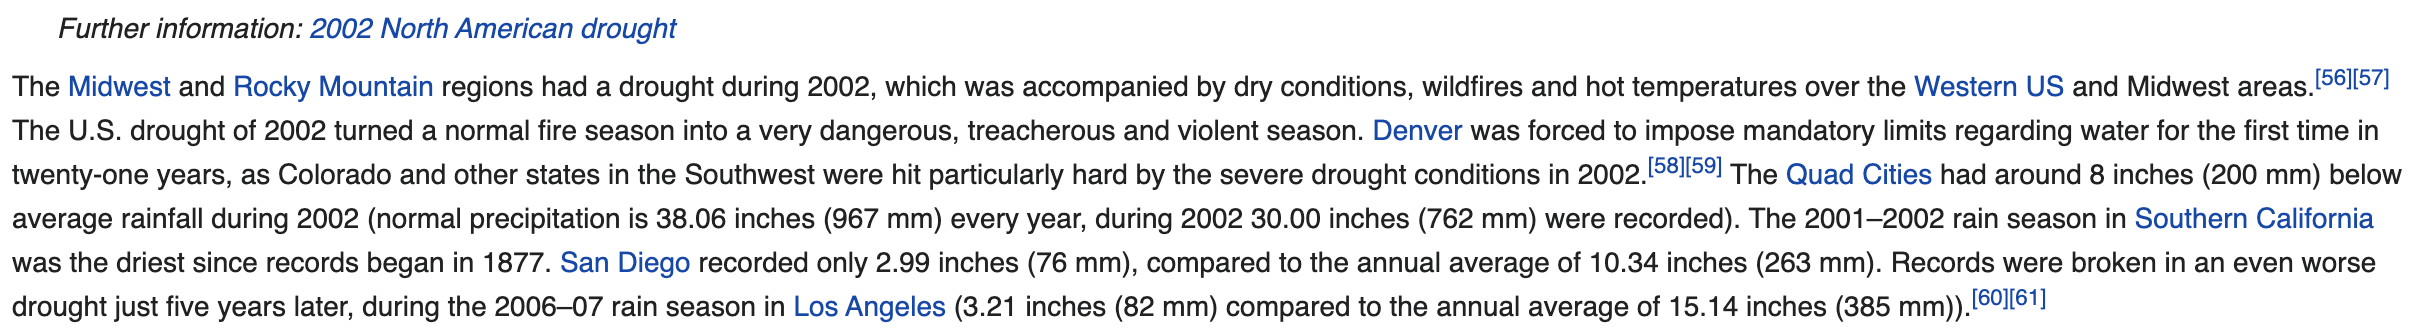

  * *Note:* **What happened in 2012**?
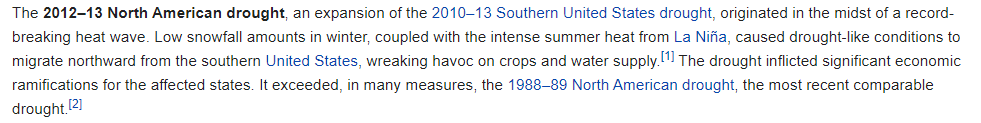

## Part 5 - Base Model



*   We chose a linear regression model named **Lasso**.
*   Lasso is a popular regularization L1 model. It adds to the loss function absolute values of the coefficients. During the optimization process coefficients of unimportant features may become zeroes, so Lasso regression allows for automated feature selection.
*   The code is taken from https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3



####5.1. Lasso Regressor

In [23]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
def split_dataset_to_data_and_labels(dataset):
  labels = dataset.score
  dataset_without_labels = dataset.drop('score',axis=1)
  return dataset_without_labels, labels

In [25]:
def plotModelResults(model, X_train, y_train, X_test, y_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    tscv = TimeSeriesSplit(n_splits = 20)

    prediction = model.predict(X_test)
    
    plt.figure(figsize=(12, 6))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, cv = tscv,
                                    scoring="neg_mean_absolute_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bound / lower bound", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    plt.title("Actual VS Prediction", fontsize=TITLE_SIZE)
    plt.xlabel("sample", fontsize=XLABEL_SIZE)
    plt.ylabel("score", fontsize=YLABEL_SIZE)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [26]:
def plotCoefficients(model, x_train):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, x_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(12, 6))
    plt.title("features coefficients", fontsize=TITLE_SIZE)
    plt.xlabel("feature", fontsize=XLABEL_SIZE)
    plt.ylabel("coefficient", fontsize=YLABEL_SIZE)
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [27]:
def lasso_regressor(x_train, y_train):
  lasso = LassoCV(max_iter=100000, tol=0.01, normalize=True)
  lasso.fit(x_train, y_train)
  return lasso

####5.2. Run and plot the results

In [67]:
# Create Training (2000-2014) and Test(2014-2016).
train = dfw[:731]
test = dfw[731:]

# Split the dataset to data without labels and labels only.
x_train, y_train = split_dataset_to_data_and_labels(train)
x_test, y_test = split_dataset_to_data_and_labels(test)

# Fit the Lasso regressor and predict the test set.
lasso = lasso_regressor(x_train, y_train)
prediction = lasso.predict(x_test)

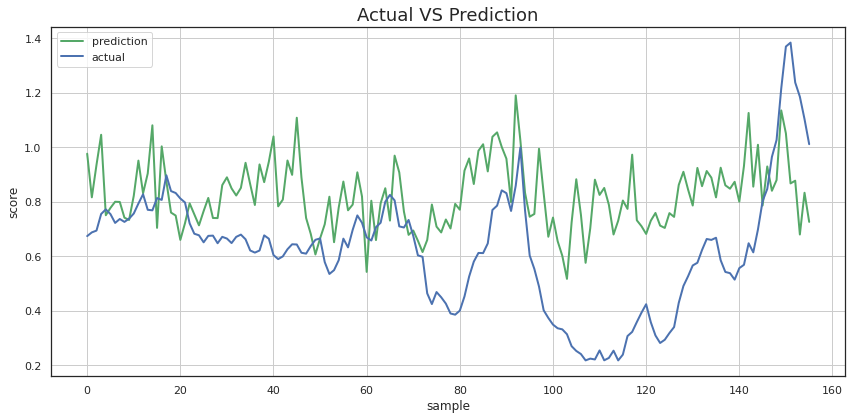

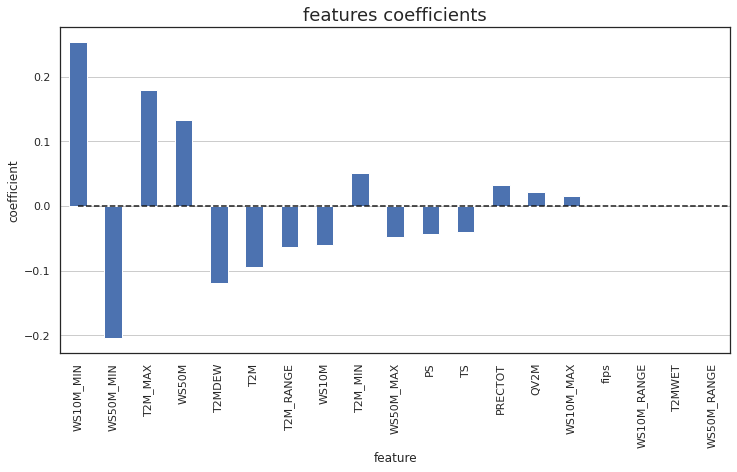

In [68]:
# Plot the running results.
plotModelResults(lasso, X_train=x_train, y_train=y_train, X_test=x_test, y_test=y_test)
plotCoefficients(lasso, x_train)

*   In the upper graph we see the comparation between the actual values (blue line) and the predicted values (green line).
*   In the lower graph we see the features coefficients that can teach us about the important features. Lasso dropped 4 features - fips, WS10M_RANGE, T2MWET, WS50M_RANGE.

####5.3. Choosing the Error Function



*   Comparation between 3 loss functions: 
    *   MAE - Mean Absolute Error (L1 Loss)
    *   MSE - Mean Squared Error (L2 loss)
    *   MAPE -  Mean Absolute Percentage Error




In [ ]:
def compare_errors(y_true, y_pred):
  print("True | Pred | MAE  | MSE  | MAPE")
  for true, pred in zip(y_true, y_pred):
    mae = np.sum(np.abs(true - pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    mse = np.sum((true - pred)**2)
    print("{0:.2f} |".format(true), "{0:.2f} |".format(pred), "{0:.2f} |".format(mae), "{0:.2f} |".format(mse), "{0:.2f}%".format(mape))
compare_errors(y_test, prediction)

In [31]:
error = mean_absolute_percentage_error(y_test, prediction)
print("Mean Absolute Percentage Error: {0:.2f}%".format(error))
print("Mean Absolute Error: {0:.2f}".format(mean_absolute_error(y_test, prediction)))
print("Mean Squared Error: {0:.2f}".format(mean_squared_error(y_test, prediction)))

Mean Absolute Percentage Error: 56.06%
Mean Absolute Error: 0.25
Mean Squared Error: 0.09



Based on the comparation above:
*   The Mean Absolute Error is better than the Mean Squared Error because it is more precise. In our case, the residuals (errors) are so close to zero, so the MSE is also very close to zero or zero.
*   We chose to use the Mean Absolute Percentage Error because the percentage is equivalent to MAE, but it is easier to conceptualize the error.

*   So, from now on we will use the MAPE to calculate the error. 



####5.4. Cross Validation



*   After choosing the error function, we will it in the cross validation process to minimise the error.



In [32]:
X, y = split_dataset_to_data_and_labels(dfw)
cross_validation_lasso(X, y)

In [36]:
def cross_validation_lasso(X, y):  
  tscv = TimeSeriesSplit(n_splits=10)
  for train_index, test_index in tscv.split(X):
      X_train, X_test = X.iloc[:train_index[len(train_index) - 1]], X.iloc[test_index[0]:test_index[len(test_index) - 1]]
      y_train, y_test = y.iloc[:train_index[len(train_index) - 1]], y.iloc[test_index[0]:test_index[len(test_index) - 1]]
      prediction = lasso_regressor(X_train, y_train).predict(X_test)
      error = mean_absolute_percentage_error(y_test, prediction)
      print("Train size: {}, Test size: {}, Mean Absolute Percentage Error: {}%".format(X_train.shape[0], X_test.shape[0],error))

Train size: 86, Test size: 79, Mean Absolute Percentage Error: 18.99397015164237%
Train size: 166, Test size: 79, Mean Absolute Percentage Error: 50.462836772688945%
Train size: 246, Test size: 79, Mean Absolute Percentage Error: 67.69618532020719%
Train size: 326, Test size: 79, Mean Absolute Percentage Error: 26.129572033067213%
Train size: 406, Test size: 79, Mean Absolute Percentage Error: 21.381060931279563%
Train size: 486, Test size: 79, Mean Absolute Percentage Error: 207.05494676461745%
Train size: 566, Test size: 79, Mean Absolute Percentage Error: 25.51415824166367%
Train size: 646, Test size: 79, Mean Absolute Percentage Error: 31.915583766639095%
Train size: 726, Test size: 79, Mean Absolute Percentage Error: 22.356276447471387%
Train size: 806, Test size: 79, Mean Absolute Percentage Error: 86.69256407961625%




*   Above you can see the results of the cross validation.
*   the split we chose is: 
    * train size:  (726, 19)
    * test size:  (79, 19)
    * Mean Absolute Percentage Error: 22.36%
*   We chosed that because the training set and the test set size together are almost in the size of the original set.
*   Now, Let's run the Lasso model with training set on size (726, 19) and test set on size (79, 19):



In [37]:
X_train, X_test = X.iloc[:726], X.iloc[726:805]
y_train, y_test = y.iloc[:726], y.iloc[726:805]
prediction = lasso_regressor(X_train, y_train).predict(X_test)
error = mean_absolute_percentage_error(y_test, prediction)
print("Train size: {}, Test size: {}, Mean Absolute Percentage Error: {}%".format(X_train.shape[0], X_test.shape[0],error))

Train size: 726, Test size: 79, Mean Absolute Percentage Error: 21.393646603680608%


## Part 6 - Basic Model Explainability



*   In this part we will explain the results of the Basic Model, identify it's error and will try to understand why those errors happened.


#####6.1. Residuals - Calculate the Maximum Error on the test set.

In [38]:
residuals = y_test - prediction
max_error = max(prediction) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], prediction[max_idx]
print("Max Error:", "{:.2f}".format(max_error))
print("Max True: {:.2f}, Max Prediction: {:.2f}".format(max_true, max_pred))

Max Error: -0.47
Max True: 0.64, Max Prediction: 1.11


#####6.2. Residuals Histogram

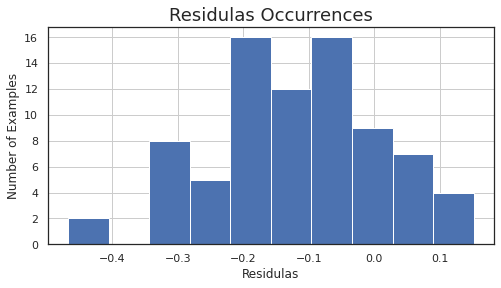

In [39]:
residuals.hist(figsize=FIG_SIZE)
plt.xlabel('Residulas', fontsize=XLABEL_SIZE)
plt.ylabel('Number of Examples', fontsize=YLABEL_SIZE)
plt.title('Residulas Occurrences', fontsize=TITLE_SIZE)
plt.show()

*   Negative residuals => y_true < y_prediction => over estimates
*   The miskates range is wide scale from -0.47 to 0.2.
*   We can see a tendency to predict the score higher than it should be.
*   Also, there is a significant peaks in -0.2 and 0.0.



#####6.3. Plot the True Values Against the Predicted Values in absolute value and percentage

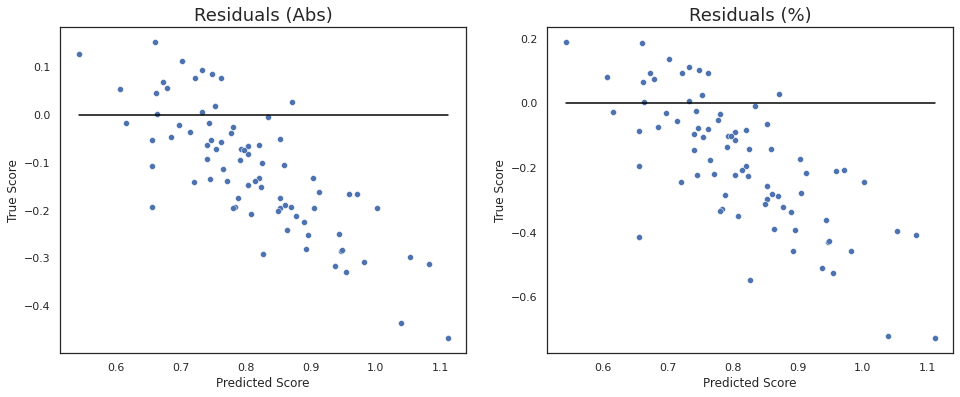

In [40]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.scatterplot(x=prediction,y=residuals,ax=ax[0])
sns.lineplot(x=prediction,y=0,ax=ax[0],color='black')
ax[0].set_title("Residuals (Abs)", fontsize=TITLE_SIZE)
ax[0].set_xlabel('Predicted Score', fontsize=XLABEL_SIZE);
ax[0].set_ylabel('True Score', fontsize=YLABEL_SIZE);

# The error percentage out of the scores value
sns.scatterplot(x=prediction,y=residuals/y_test,ax=ax[1])
sns.lineplot(x=prediction,y=0,ax=ax[1],color='black')
ax[1].set_title('Residuals (%)', fontsize=TITLE_SIZE)
ax[1].set_xlabel('Predicted Score', fontsize=XLABEL_SIZE);
ax[1].set_ylabel('True Score', fontsize=YLABEL_SIZE);
plt.show()

*   Clearly the Lasso's predictions are lower than they should be.
*   In most cases the model over estimates the score.

#####6.4. Explore and understand on which examples we predicted best (and worst...)

In [41]:
rel_res=residuals/y_test
rel_res=rel_res.abs()

*   Our model works best (error less than 5%) for 11% of the test data

In [42]:
len(rel_res[rel_res<0.05])/len(rel_res)

0.11392405063291139

*   Our model had bigger mistakes (more than 20%) on 47% of the test data

In [43]:
len(rel_res[rel_res>0.2])/len(rel_res)

0.46835443037974683

#####6.5. Model explainability using **SHAP**

In [44]:
shap_sample = X_train.sample(500)

In [45]:
explainer = shap.Explainer(lasso.predict, shap_sample)
shap_values = explainer(shap_sample)

Permutation explainer: 501it [00:19, 14.92it/s]                         


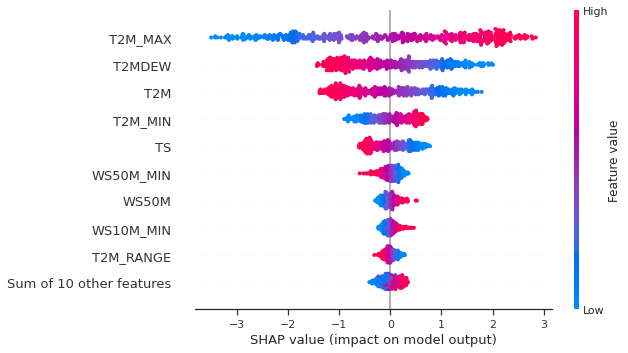

In [46]:
shap.plots.beeswarm(shap_values)


*   Overall, the features impact the same way on the score. In all cases we can see symmetrical results with high values and low.
*   for example, in T2M_MAX when the value is low, the impact is negative and when the value is high the impact is high. 




In [47]:
test_shap_values = explainer(X_test)



*   Let's explore the sample that got the highset residual.


In [48]:
rel_res[rel_res==rel_res.max()]

date
2014-11-23    0.726885
Freq: W-SUN, Name: score, dtype: float64

In [49]:
X_test.index.get_loc('2014-11-23')

50

In [50]:
X_test[rel_res==rel_res.max()]

fips   PRECTOT         PS  ...  WS50M_MAX  WS50M_MIN  WS50M_RANGE
date                                          ...                                   
2014-11-23  30670.37677  0.192648  97.036721  ...   9.025586   4.610901     4.414585

[1 rows x 19 columns]

In [51]:
y_test.loc['2014-11-23'],prediction[50]

(0.6432366151866156, 1.1107954217492813)

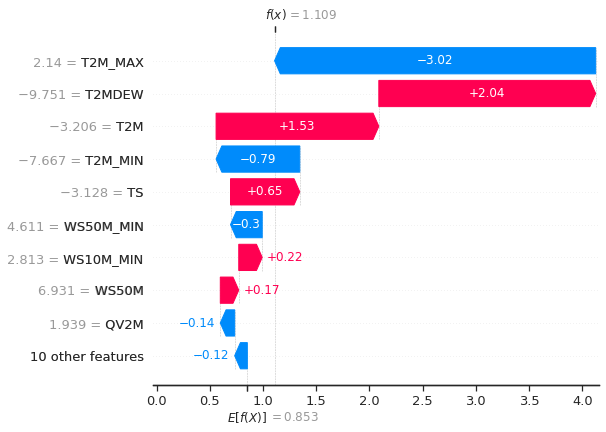

In [52]:
shap.plots.waterfall(test_shap_values[50])



*   We can see that T2M_MAX has high impact on the score in the negative way. But, the T2MDEW and T2M cancel that impact with high positive values. 
*   Below we can see boxplots for the three most influence features.



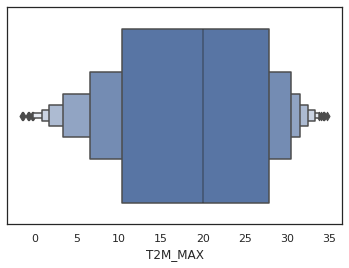

In [53]:
sns.boxenplot(x=X_train.T2M_MAX)

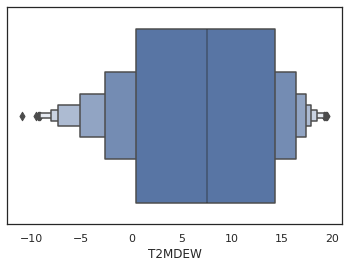

In [54]:
sns.boxenplot(x=X_train.T2MDEW)

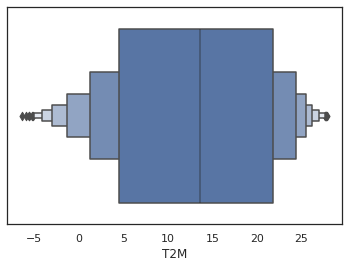

In [55]:
sns.boxenplot(x=X_train.T2M)



*   Overall, there aren't significant outliers.


In [56]:
len(residuals[residuals<-0.1])

43



*   Now, let's focus on the samples with the highest residuals.


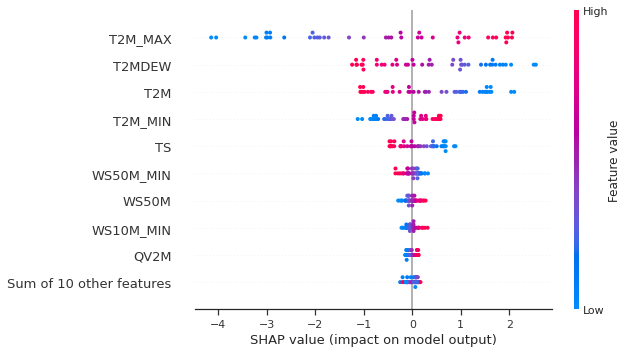

In [57]:
bad_examples = X_test.loc[residuals[residuals<-0.1].index]
bad_examples_shap_values = explainer(bad_examples)
shap.plots.beeswarm(bad_examples_shap_values)



*   We can see that there is an low impact on low values for the T2M_MAX.
*   But, there is also high impact on low values as well for the T2MDEW and T2M.



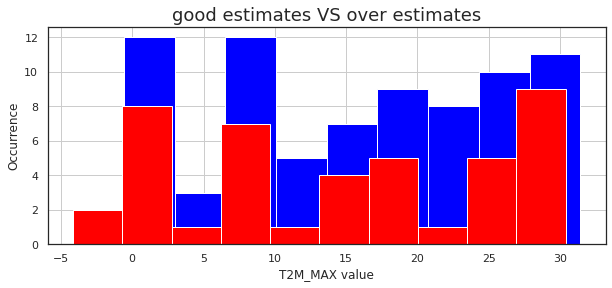

In [58]:
over_estimates = X_test.loc[residuals[residuals<-0.1].index]
good_estimates = X_test.loc[rel_res[rel_res>-0.1].index]
fig, ax = plt.subplots(figsize=(10,4))
good_estimates.T2M_MAX.hist(ax=ax,color='blue')
over_estimates.T2M_MAX.hist(ax=ax,color='red')
plt.xlabel("T2M_MAX value", size=XLABEL_SIZE)
plt.ylabel("Occurrence", size=YLABEL_SIZE)
plt.title("good estimates VS over estimates", size=TITLE_SIZE)
plt.show()

## Part 7 - ARIMA MODEL

In [60]:
def fit_ARIMA(p1,d1,q1, p2,d2,q2):
  model = ARIMA(np.log(dfw.score).dropna(), (p1,d1,q1))
  res_0 = model.fit()
  print(res_0.summary())

  model = ARIMA(np.log(dfw.score).dropna(), (p2,d2,q2))
  res_1 = model.fit()
  print(res_1.summary())
  
  fig, ax = plt.subplots(1, 2, sharey=True, figsize=FIG_SIZE)
  ax[0].plot(res_0.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_0.resid.values)));
  ax[0].hlines(0, xmin=0, xmax=350, color='r');
  ax[0].set_title("ARIMA ({}, {}, {}) Residuals".format(p1,d1,q1));
  ax[0].set_ylabel("residuals");
  ax[0].set_xlabel("example number");
  ax[0].legend();
  ax[1].plot(res_1.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_1.resid.values)));
  ax[1].hlines(0, xmin=0, xmax=350, color='r');
  ax[1].set_title("ARIMA ({}, {}, {}) Residuals".format(p2,d2,q2));
  ax[1].set_ylabel("residuals");
  ax[1].set_xlabel("example number");
  ax[1].legend();

####7.1.Choosing the differencing order

Based on the analysis in part 4, the data needs only one order of difference. So, let’s check our results by comparing ARIMA(0, 0, 0) and ARIMA(0, 1, 0) while d = 1 = 1nd order difference.

                              ARMA Model Results                              
Dep. Variable:                  score   No. Observations:                  887
Model:                     ARMA(0, 0)   Log Likelihood                -662.726
Method:                           css   S.D. of innovations              0.511
Date:                Mon, 23 Aug 2021   AIC                           1329.451
Time:                        12:01:37   BIC                           1339.027
Sample:                    01-09-2000   HQIC                          1333.112
                         - 01-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3060      0.017    -17.840      0.000      -0.340      -0.272
                             ARIMA Model Results                              
Dep. Variable:                D.score   No. Observat

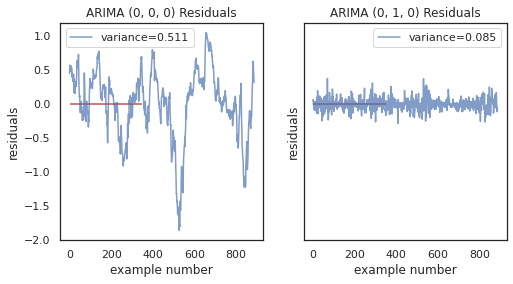

In [61]:
fit_ARIMA(0,0,0,0,1,0)

* The Akaike Information Criterion (AIC) is lower with the ARIMA(0,1,0), meaning 
this model performs better than the ARIMA(0,0,0).

* Also, the variances of the residuals graphs - the ARIMA(0,1,0) variance is lower (0.085) than ARIMA(0,0,0).

* To conclude: d = 1.

####7.2.Choosing the MA order

* Rule: “ If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1”.
* Based on that rule we will try to run the model with (1,1,0) and compare it to (0,1,0). results:

                             ARIMA Model Results                              
Dep. Variable:                D.score   No. Observations:                  886
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 950.199
Method:                       css-mle   S.D. of innovations              0.083
Date:                Mon, 23 Aug 2021   AIC                          -1894.399
Time:                        12:01:41   BIC                          -1880.039
Sample:                    01-16-2000   HQIC                         -1888.909
                         - 01-01-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.004     -0.047      0.963      -0.007       0.007
ar.L1.D.score     0.2151      0.033      6.554      0.000       0.151       0.279
                                    Root

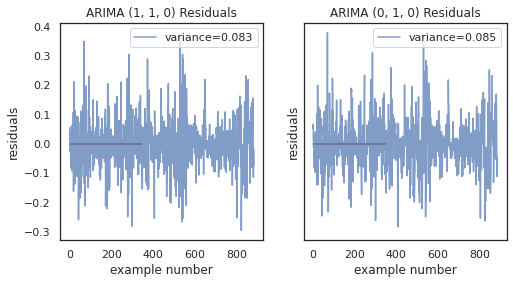

In [62]:
fit_ARIMA(1,1,0,0,1,0)

* The AIC has dropped again and the residuals variance decreased also. That’s a sign our ARIMA(1,1,0) performs better than the ARIMA(0,1,0) !

* To conclude: p = 1

####7.3.Choosing the AR order



*   Rule: “If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1.”
*   By this rule and looking at our PACF difference graph we will try to run the model with (1,1,1) and compare it to (1,1,0). 



                             ARIMA Model Results                              
Dep. Variable:                D.score   No. Observations:                  886
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 951.011
Method:                       css-mle   S.D. of innovations              0.083
Date:                Mon, 23 Aug 2021   AIC                          -1894.022
Time:                        12:01:46   BIC                          -1874.875
Sample:                    01-16-2000   HQIC                         -1886.702
                         - 01-01-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.004     -0.045      0.964      -0.007       0.007
ar.L1.D.score     0.4067      0.138      2.946      0.003       0.136       0.677
ma.L1.D.score    -0.2016      0.148     

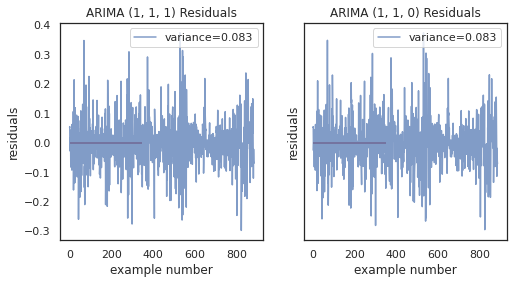

In [63]:
fit_ARIMA(1,1,1,1,1,0)



*   The residuals variances are the same in both cases, but the AIC of ARIMA(1,1,0) is lower than ARIMA(1,1,1).

*   To conclude, the best parameters are (1,1,0).



####7.4.Prediction

*   Now, we will split the dataset using cross validation, then fit the ARIMA model with parameters (1,1,0) and predict on the test set.


In [ ]:
X, y = split_dataset_to_data_and_labels(dfw)
cross_validation_arima(X,y)

In [64]:
def cross_validation_arima(X, y):
  tscv = TimeSeriesSplit(n_splits=10)

  for train_index, test_index in tscv.split(X):
      X_train, X_test = X.iloc[:train_index[len(train_index) - 1]], X.iloc[test_index[0]:test_index[len(test_index) - 1]]
      y_train, y_test = y.iloc[:train_index[len(train_index) - 1]], y.iloc[test_index[0]:test_index[len(test_index) - 1]]
      # Build the ARIMA Model.
      model = ARIMA(y_train, order=(1, 1, 0))  
      fitted = model.fit(disp=-1) 
      # Forecast
      fc, se, conf = fitted.forecast(X_test.shape[0], alpha=0.05)  # 95% conf
      # Make as pandas series.
      prediction = pd.Series(fc, index=y_test.index)
      # calculate the error.
      error = mean_absolute_percentage_error(y_test, prediction)
      print("Train size: {}, Test size: {}, Mean Absolute Percentage Error: {}%".format(X_train.shape[0], X_test.shape[0],error))

Time Series Cross Validation params:  TimeSeriesSplit(max_train_size=None, n_splits=10)
X_train size:  (86, 19)
X_test size:  (79, 19)
Mean Absolute Percentage Error: 58.10%
X_train size:  (166, 19)
X_test size:  (79, 19)
Mean Absolute Percentage Error: 39.21%
X_train size:  (246, 19)
X_test size:  (79, 19)
Mean Absolute Percentage Error: 48.16%
X_train size:  (326, 19)
X_test size:  (79, 19)
Mean Absolute Percentage Error: 31.83%
X_train size:  (406, 19)
X_test size:  (79, 19)
Mean Absolute Percentage Error: 103.96%
X_train size:  (486, 19)
X_test size:  (79, 19)
Mean Absolute Percentage Error: 90.79%
X_train size:  (566, 19)
X_test size:  (79, 19)
Mean Absolute Percentage Error: 19.89%
X_train size:  (646, 19)
X_test size:  (79, 19)
Mean Absolute Percentage Error: 29.97%
X_train size:  (726, 19)
X_test size:  (79, 19)
Mean Absolute Percentage Error: 11.96%
X_train size:  (806, 19)
X_test size:  (79, 19)
Mean Absolute Percentage Error: 38.34%


*   The split with the lowest error is: 
    * train size:  (726, 19)
    * test size:  (79, 19)
    * Mean Absolute Percentage Error: 11.96%
*   That the same split we chose before in the CV of Lasso model.
*   Now, Let's run the ARIMA model with training set on size (726, 19) and test set on size (79, 19):

In [ ]:
run_arima_and_plot_results();

In [65]:
def run_arima_and_plot_results():
  X_train, X_test = X.iloc[:726], X.iloc[726:805]
  y_train, y_test = y.iloc[:726], y.iloc[726:805]
  # Build Model
  model = ARIMA(y_train, order=(1, 1, 0))  
  fitted = model.fit(disp=-1)
  # Forecast
  fc, se, conf = fitted.forecast(X_test.shape[0], alpha=0.05)  # 95% conf
  # Make as pandas series
  fc_series = pd.Series(fc, index=y_test.index)
  lower_series = pd.Series(conf[:, 0], index=y_test.index)
  upper_series = pd.Series(conf[:, 1], index=y_test.index)

  error = mean_absolute_percentage_error(y_test, fc_series)
  print("Train size: {}, Test size: {}, Mean Absolute Percentage Error: {}%".format(X_train.shape[0], X_test.shape[0],error))

  # Plot
  plt.figure(figsize=FIG_SIZE, dpi=100)
  plt.plot(y_train, label='training')
  plt.plot(y_test, label='actual')
  plt.plot(fc_series, label='forecast')
  plt.fill_between(lower_series.index, lower_series, upper_series, 
                  color='k', alpha=.15)
  plt.title('Forecast vs Actuals', fontsize=TITLE_SIZE)
  plt.xlabel('Year', fontsize=XLABEL_SIZE)
  plt.ylabel('average score', fontsize=YLABEL_SIZE)
  plt.legend(loc='upper left', fontsize=8)
  plt.show()

X_train size:  (726, 19)
X_test size:  (79, 19)
Mean Absolute Percentage Error: 11.08%




*   The model learned the examples of 2000-2014 and predicted the score on 2014-2016.
*   As we can see the forcast (green line) is relatively close to the actual (orange line).



## Part 8 - Conclusions

## Part 9 - Attachments

####1. Features correlation with first order differences on the data

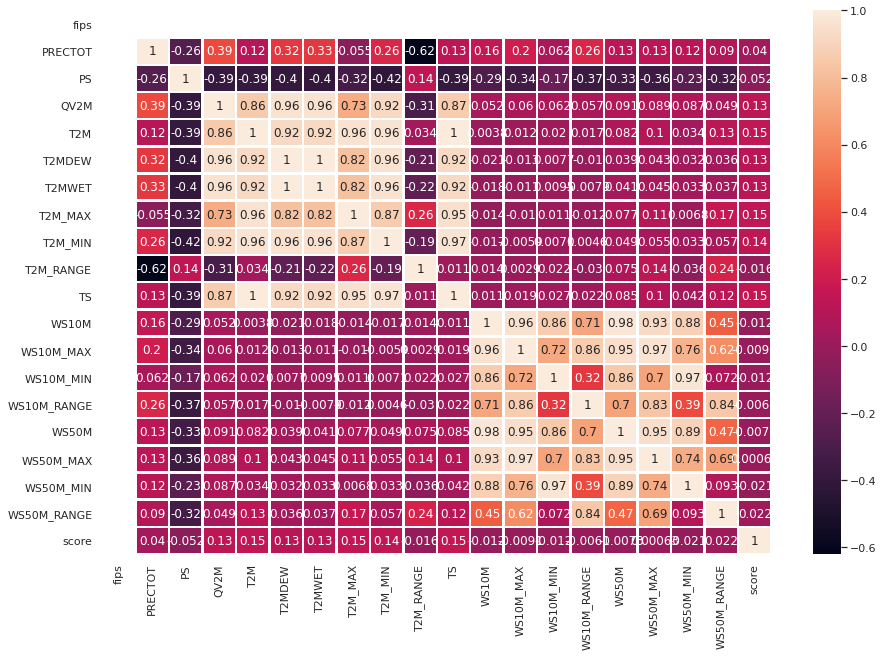

In [71]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(dfw.diff().corr(method='spearman'),annot=True,linewidths=1.5, ax=ax)
plt.show()

*   As we can see, the features with the highest correlations with the Score are:
    * T2M, T2M_MAX, TS - 0.15
    * T2M_MIN - 0.14
    * QV2M, T2NDEW, T2MWET - 0.13


####2. Logistic Regression Model 


*   First, we designed our question as Classification one - "What will be the drought level next week?" (levels: no drought, D0, D1, D2, D3, D4).
*   Here there is a try to run Logistic Regression Model for Classification question. 



#####2.1. Preprocessing

In [72]:
def convert_reg_score_to_categories(input_labels):
  """
  bins:
  [0,1) - 0, no drought
  [1,2) - D0
  [2,3) - D1
  [3,4) - D2
  [4,5) - D3
  [5, ++++) - D4
  """
  categorical_scores = []
  for i in input_labels:
    if i < 1:
      i = 0
    elif i >= 1 and i < 2:
      i = 1
    elif i >= 2 and i < 3:
      i = 2
    elif i >= 3 and i < 4:
      i = 3
    elif i >= 4 and i < 5:
      i = 4
    elif i >= 5:
      i = 5
    else:
      continue
    categorical_scores.append(i)
  return categorical_scores

In [73]:
logreg = linear_model.LogisticRegression(max_iter = 10000)

#Seperate the score label from train_data
train = train_data.copy()
score_labels = train.score
train_data_no_score = train.drop('score',axis=1)
categorical_scores = convert_reg_score_to_categories(score_labels)

train_data_no_score = train_data_no_score[:100000]
categorical_scores = categorical_scores[:100000]

#####2.2. Fitting the Logistic Regression Model

In [74]:
 logreg.fit(train_data_no_score, categorical_scores)
 print(logreg)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


#####2.3. Evaluate Results on the Validation Set

In [75]:
validation = validation_data.copy()
validation_score_labels = validation.score
validation_no_score = validation.drop('score',axis=1)
categorical_scores_validation = convert_reg_score_to_categories(validation_score_labels)

NameError: ignored

In [ ]:
predicted = logreg.predict(validation_no_score)
predicted_probs = logreg.predict_proba(validation_no_score)

print(metrics.classification_report(categorical_scores_validation[:100000], predicted[:100000]))



*   We evaluate the model on 100,000 samples only, otherwise the session is crashing.
*   From the report we can see that the accuracy is 0.7.
*   The precisions and recalls are high for the samples with 0 (no drought), but very low in other levels of drought.
*   Most of the samples are with no drought. 



#####2.4. Evaluate Results on the Test Set 

In [ ]:
test = test_data.copy()
test_score_labels = test.score
test_no_score = test.drop('score',axis=1)
categorical_scores_test = convert_reg_score_to_categories(test_score_labels)

In [ ]:
predicted = logreg.predict(test_no_score)
predicted_probs = logreg.predict_proba(test_no_score)

print(metrics.classification_report(categorical_scores_validation[:100000], predicted[:100000]))



*   The results of the test set are approximately the same as on the validation set.
*   List item



In [ ]:
y_true = categorical_scores_test
y_score = predicted_probs

n_classes = 6
y = label_binarize(y_true, classes=np.arange(n_classes))

#####2.5. Precision-Recall Curve

In [ ]:
precision = dict()
recall = dict()

plt.figure(figsize=FIG_SIZE)
for i in range(n_classes):
    precision[i], recall[i], _ = sklearn.metrics.precision_recall_curve(y[:, i], y_score[:, i], pos_label=1)
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall", fontsize=XLABEL_SIZE)
plt.ylabel("precision", fontsize=YLABEL_SIZE)
plt.legend(loc="best")
plt.title("Precision Recall Curve", fontsize=TITLE_SIZE)
plt.show()



*   The precision Recall Curve shows the tradeoff between precision and recall for different threshold.
*   The area under the curve in **class 0** is high, so the recall and precision are both high as we saw before in the report.
*   The other classes have low area under the curve which represents both low recall and precision.
*   High precision relates to a low false positive rate, and high recall relates to a low false. That's true for class 0. For the other classes we’re gonna need to make some improvements. 



#####2.6. ROC Curve

In [ ]:
def plotRoc(fpr, tpr, auc):
    plt.figure(figsize=FIG_SIZE)
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=XLABEL_SIZE)
    plt.ylabel('True Positive Rate', fontsize=YLABEL_SIZE)
    plt.title('Receiver Operating Characteristic', fontsize=TITLE_SIZE)
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
auc = sklearn.metrics.roc_auc_score(y_true, y_score, multi_class='ovr')
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score[:, 1], pos_label=1)
plotRoc(fpr, tpr, auc)



*   The AUC is 0.62 which is quite good for the Basic Model, but we’re gonna need to make some improvements so the true positive rate will be close to 1 and thhe false positive rate will be close to 0.
*   Our goal is to close the curve to 1.0 in the true positive rate.



#####2.7. Conclusions


*   Given another thought about this model, we decided to rephrase our question and to solve a Regression problem: 

  *   "What will be the score next week?" (a number between 0-5)
*   We decided that because we understood that the model looses important information while designing as Classification problem. 

*   In the next step, we spent more time to explore the Seasonality, Trends and Stationary of the data. than, we tried models that desighed specifically for time series data that solves a Regression problem, but also models for stationary data.





####3. Checking the best parameters for SARIMA Model



*   Let's check the best parameters for SARIMA Model:


In [ ]:
train_st = dfw.score[:731]
test_st = dfw.score[731:]
p = range(0, 3)
d = range(0,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
aic = []
params = []
params_seasonal = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train_st, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            aic.append(results.aic)
            params.append(param)
            params_seasonal.append(param_seasonal)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1990.8018345106975
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1280.7372631135217
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:863.4445500191853
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:294.8463218445687
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:280.50297517613376
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:277.64298538841473
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:270.9112064348911
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:263.09013775260945
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:264.48442632015724
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:282.5812826586653
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:228.70888502362476
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:226.48637291339904
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:266.63827805173594
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:228.99609002141895
ARIMA(0, 0, 0)x(2, 0, 2


*   Given a collection of parameters for the data, the AIC estimates the quality of each parameters on the model. The parameters (1,1,0) from ARIMA and the the seasonal parameters (0,0,0,12) got one of the lowest AIC. 
*   Because of the seasonal parameters are zero, we should not try the SARIMA Model.




####4. Random Forest Regresssor

#####4.1. Methods

In [ ]:
def tune(dataset_without_labels, lables):
  model = RandomForestRegressor()
  gcv = GridSearchCV(model, {"max_features": [2, 4, 6, 8, 10, 12], "n_estimators": [100, 200, 500, 1000], "max_depth": [3, 4, 5]}, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
  gcv.fit(dataset_without_labels, lables)
  return gcv.best_params_

In [ ]:
def fit(best_params, dataset_without_labels, lables):
  model = RandomForestRegressor(n_estimators=best_params["n_estimators"],
                                max_depth=best_params["max_depth"],
                                max_features=best_params["max_features"])
  model.fit(dataset_without_labels, lables)
  return model

#####4.2. Splitting to train and test

In [ ]:
# Create Training and Test
train = dfw[:731]
test = dfw[731:]

#####4.3. Fitting the model on the train set

In [ ]:
train_data_without_labels, train_labels = split_dataset_to_data_and_labels(train)
best_params = tune(train_data_without_labels, train_labels)
model = fit(best_params, train_data_without_labels, train_labels)

KeyboardInterrupt: ignored

In [ ]:
mean_absolute_percentage_error(train_data_without_labels, train_labels)

#####4.4. Prediction

In [ ]:
test_data_without_labels, test_labels = split_dataset_to_data_and_labels(test)
predicted = model.predict(test_data_without_labels)

error = mean_absolute_percentage_error(test_labels, predicted)
print("Mean Absolute Percentage Error: {0:.2f}%".format(error))

#####4.5. Walk Forward validation

###### Concatenate Train, Validation ans Test datasets

In [ ]:
frames = [train_data, validation_data, test_data]
df_train = pd.concat(frames)

# drop Nan values.
df_train = df_train.dropna()
# set the Datetime feature as an index.
df_train['datetime'] = pd.to_datetime(df_train.date)
df_train.set_index('datetime', inplace=True)

# sample df_train by Weeks.
df_train_W = resample_dataset(df_train, "W")

###### Walk Forward Validation

The implementation was taken from https://medium.com/eatpredlove/time-series-cross-validation-a-walk-forward-approach-in-python-8534dd1db51a 

###### Expanding window cross validation


In [ ]:
'''
Expanding window cross validation
Similar to sklearn format
@ germayne  
'''

class expanding_window(object):
    '''	
    Parameters 
    ----------
    
    Note that if you define a horizon that is too far, then subsequently the split will ignore horizon length 
    such that there is validation data left. This similar to Prof Rob hyndman's TsCv 
    
    
    initial: int
        initial train length 
    horizon: int 
        forecast horizon (forecast length). Default = 1
    period: int 
        length of train data to add each iteration 
    '''
    

    def __init__(self,initial= 1,horizon = 1,period = 1):
        self.initial = initial
        self.horizon = horizon 
        self.period = period 


    def split(self,data):
        '''
        Parameters 
        ----------
        
        Data: Training data 
        
        Returns 
        -------
        train_index ,test_index: 
            index for train and valid set similar to sklearn model selection
        '''
        self.data = data
        self.counter = 0 # for us to iterate and track later 


        data_length = data.shape[0] # rows 
        data_index = list(np.arange(data_length))
         
        output_train = []
        output_test = []
        # append initial 
        output_train.append(list(np.arange(self.initial)))
        progress = [x for x in data_index if x not in list(np.arange(self.initial)) ] # indexes left to append to train 
        output_test.append([x for x in data_index if x not in output_train[self.counter]][:self.horizon] )
        # clip initial indexes from progress since that is what we are left 
         
        while len(progress) != 0:
            temp = progress[:self.period]
            to_add = output_train[self.counter] + temp
            # update the train index 
            output_train.append(to_add)
            # increment counter 
            self.counter +=1 
            # then we update the test index 
            
            to_add_test = [x for x in data_index if x not in output_train[self.counter] ][:self.horizon]
            output_test.append(to_add_test)

            # update progress 
            progress = [x for x in data_index if x not in output_train[self.counter]]	
            
        # clip the last element of output_train and output_test
        output_train = output_train[:-1]
        output_test = output_test[:-1]
        
        # mimic sklearn output 
        index_output = [(train,test) for train,test in zip(output_train,output_test)]
        
        return index_output

###### Run the Cross Validation

In [ ]:
df_middle = int(len(dfw_diff) / 2)
df_quarter = int(len(dfw_diff) / 4)

# initial is the number of train samples. 
# horizon is the number of test samples.
# period indicated the growth of the train samples.

tscv = expanding_window(initial = df_middle, horizon = df_quarter,period = 20)

test_mean_absolute_errors, test_mean_squared_error = [], []

for train_index, test_index in tscv.split(dfw_diff):
    
    # create train_set and test_set according to the indexes lists.
    train_set = dfw_diff.iloc[:train_index[len(train_index) - 1]]
    test_set = dfw_diff.iloc[test_index[0]:test_index[len(test_index) - 1]]
    
    if len(test_set) < 100:
      continue
    
    else:
      # run the Random Forest Regressor:

      # for the training set.
      train_data_without_labels, train_labels = split_dataset_to_data_and_labels(train_set)
      best_params = tune(train_data_without_labels, train_labels)
      model = fit(best_params, train_data_without_labels, train_labels)

      # for the test set.
      test_data_without_labels, test_labels = split_dataset_to_data_and_labels(test_set)
      best_params = tune(test_data_without_labels, test_labels)
      model = fit(best_params, test_data_without_labels, test_labels)
      # predict values on test set.
      predicted = model.predict(test_data_without_labels)
      # calculate errors.
      mae = mean_absolute_error(test_labels, predicted)
      mse = mean_squared_error(test_labels, predicted)

      test_mean_absolute_errors.append(mae)
      test_mean_squared_error.append(mse)

###### Find the index and value with the minimum error

In [ ]:
print("Minimum test_mean_absolute_errors: ", test_mean_absolute_errors.index(min(test_mean_absolute_errors)))
print("Minimum test_mean_squared_error: ", test_mean_squared_error.index(min(test_mean_squared_error)))
index = test_mean_squared_error.index(min(test_mean_squared_error))

###### Fit the model to the train/test split that got the minimum error  

In [ ]:
i = 0
for train_index, test_index in tscv.split(df_train_W):
  if i == index:
    train_set = df_train_W.iloc[:train_index[len(train_index) - 1]]
    test_set = df_train_W.iloc[test_index[0] :test_index[len(test_index) - 1]]
    train_data_without_labels, train_labels = split_dataset_to_data_and_labels(train_set)

    test_data_without_labels, test_labels = split_dataset_to_data_and_labels(test_set)
    best_params = tune(test_data_without_labels, test_labels)
    model = fit(best_params, test_data_without_labels, test_labels)
    # predict values on test set.
    predicted = model.predict(test_data_without_labels)

    break
  i+=1

####5. Ridge Regressor

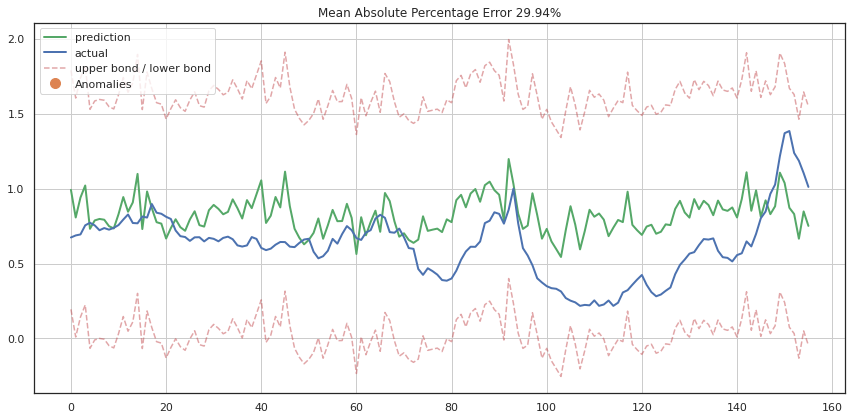

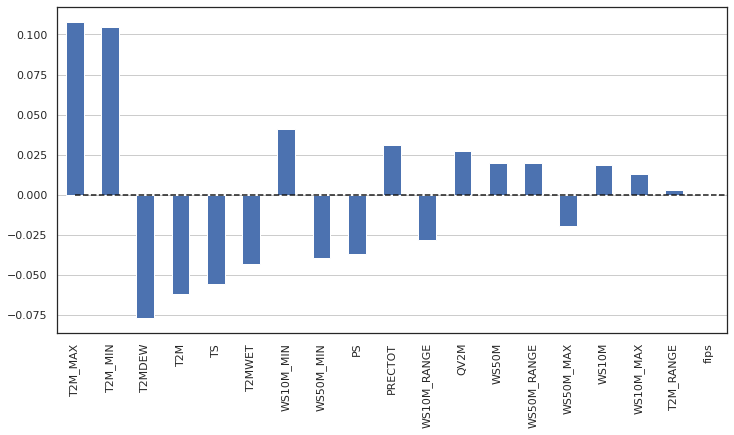

In [ ]:
train = dfw[:731]
test = dfw[731:]

x_train, y_train = split_dataset_to_data_and_labels(train)
x_test, y_test = split_dataset_to_data_and_labels(test)

ridge = RidgeCV()
ridge.fit(x_train, y_train)

plotModelResults(ridge,
                 X_train=x_train,
                 y_train=y_train, 
                 X_test=x_test, 
                 y_test=y_test,
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge, x_train)



*   Here the constrains are the sum of squares of coefficients, multiplied by the regularization coefficient.
*   We can clearly see how coefficients are getting closer and closer to zero, as their importance in the model drops



####6. XGBoost

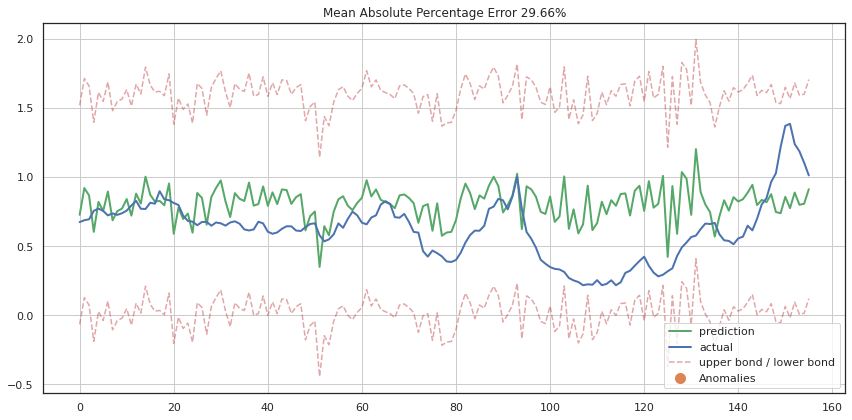

In [ ]:
train = dfw[:731]
test = dfw[731:]

x_train, y_train = split_dataset_to_data_and_labels(train)
x_test, y_test = split_dataset_to_data_and_labels(test)

xgb = XGBRegressor(silent=True)
xgb.fit(x_train, y_train)

plotModelResults(xgb, 
                 X_train=x_train,
                 y_train=y_train, 
                 X_test=x_test, 
                 y_test=y_test, 
                 plot_intervals=True, plot_anomalies=True)



*   XGBoost got the smallest error on the test set than the 2 models above.
*   XGBoost also dropped 4 features completely.

